# **Project Final Report**

## **Introduction**

**Question**: Can we use age, experience, and gender to predict the number of played hours a player will contribute to the PLAICraft server?

## **Methods and Results**

In [3]:
library(tidyverse)
library(tidymodels)
library(scales)
options(repr.matrix.max.rows = 6)
options(repr.plot.width = 12, repr.plot.height = 10)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [4]:
url_players <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
clean_player_data <- read_csv(url_players) |>
            mutate(experience = as.factor(experience)) |>     # Convert experience to factor data type
            mutate(gender = as.factor(gender)) |>     # Convert gender to factor data type
            select(-individualId, -organizationName)     # Remove unneeded columns
clean_player_data

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,age
<fct>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,91


### **Analysis**

In [5]:
set.seed(1234)

# Split Data into Training and Testing
data_split <- initial_split(clean_player_data, prop = 0.75, strata = played_hours)
data_training <- training(data_split)
data_testing <- testing(data_split)

# Setup Spec for Tuning for K
tuning_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
      set_engine("kknn") |>
      set_mode("regression") 

# Create recipe for training data
predict_recipe <- recipe(played_hours ~ experience + gender + age, data = data_training) |>
        step_dummy(experience, gender) |>
      step_scale(all_predictors()) |>
      step_center(all_predictors())

# Create workflow for cross_validation
tuning_workflow <- workflow() |>
                    add_recipe(predict_recipe) |>
                    add_model(tuning_spec)

# Setup folds & k values for folds
data_vfold <- vfold_cv(data_training, v = 5, strata = played_hours)
gridvals <- tibble(neighbors = seq(from = 1, to = 100, by = 1))

# Determine k that provides minimal RMSE
tuning_results <- tuning_workflow |>
  tune_grid(resamples = data_vfold, grid = gridvals) |>
  collect_metrics() |>
    filter(.metric == "rmse") |>
    slice_min(mean, n = 1)

→ A | warning: !  The following column has zero variance so scaling cannot be used:
                 gender_Other.
               ℹ Consider using ?step_zv (`?recipes::step_zv()`) to remove those columns
                 before normalizing.

There were issues with some computations   A: x1

There were issues with some computations   A: x1





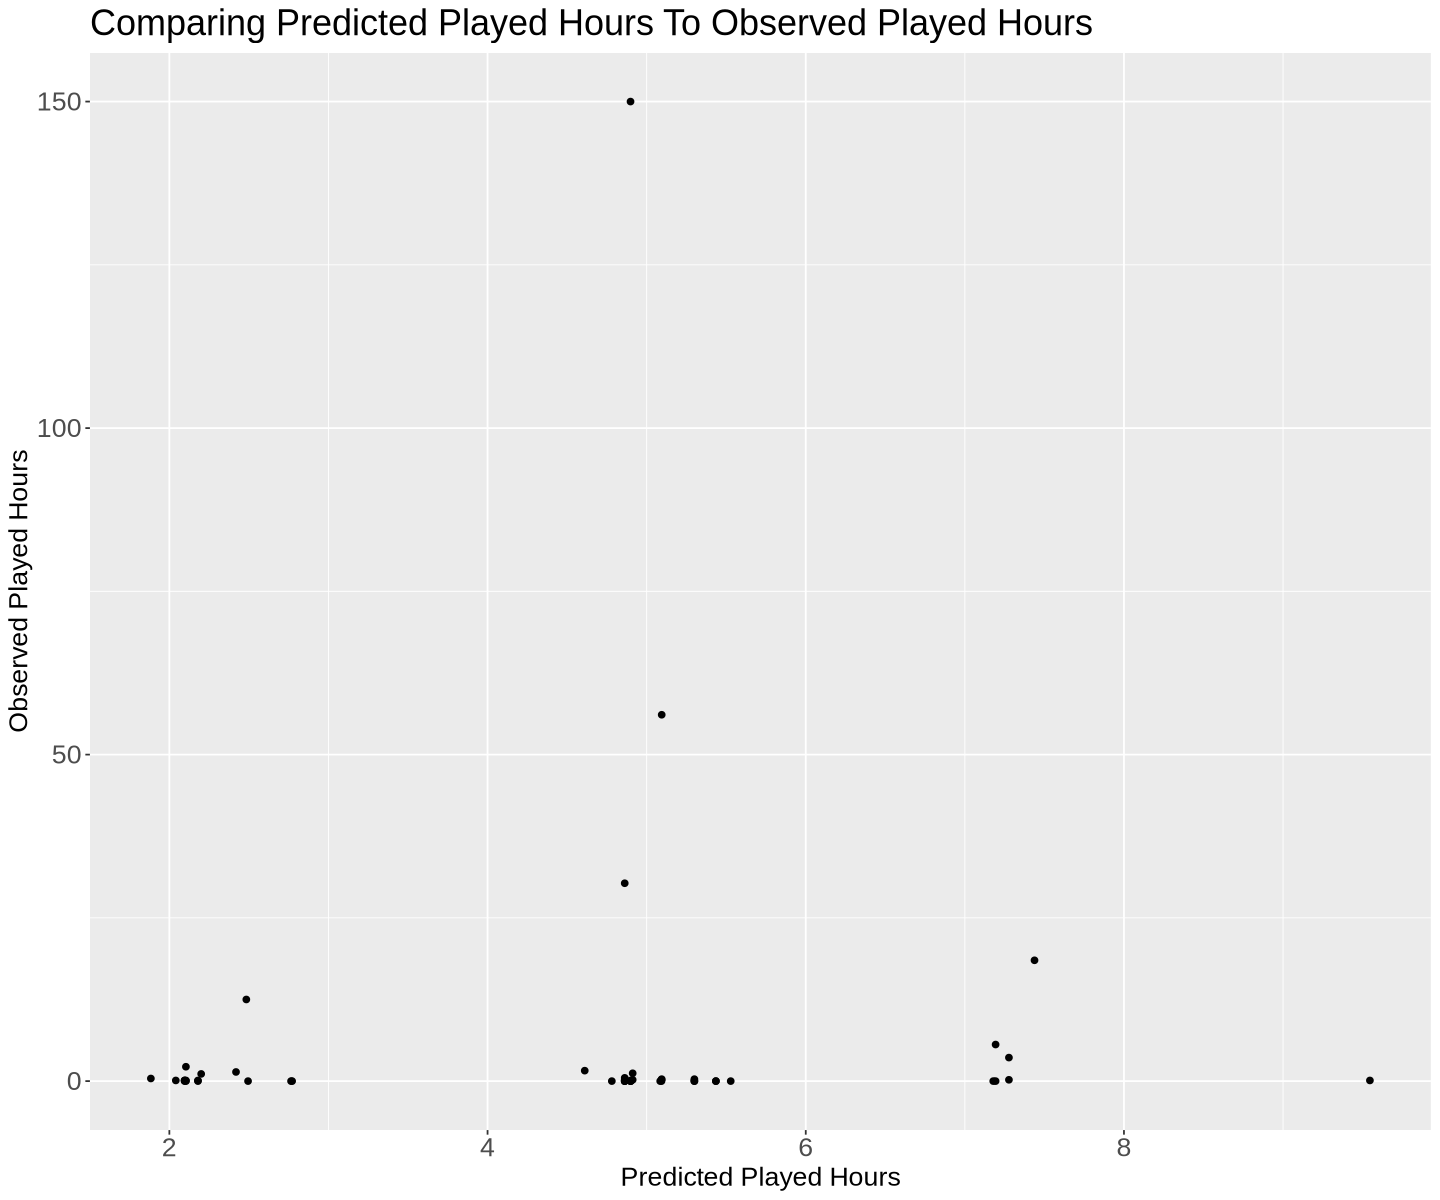

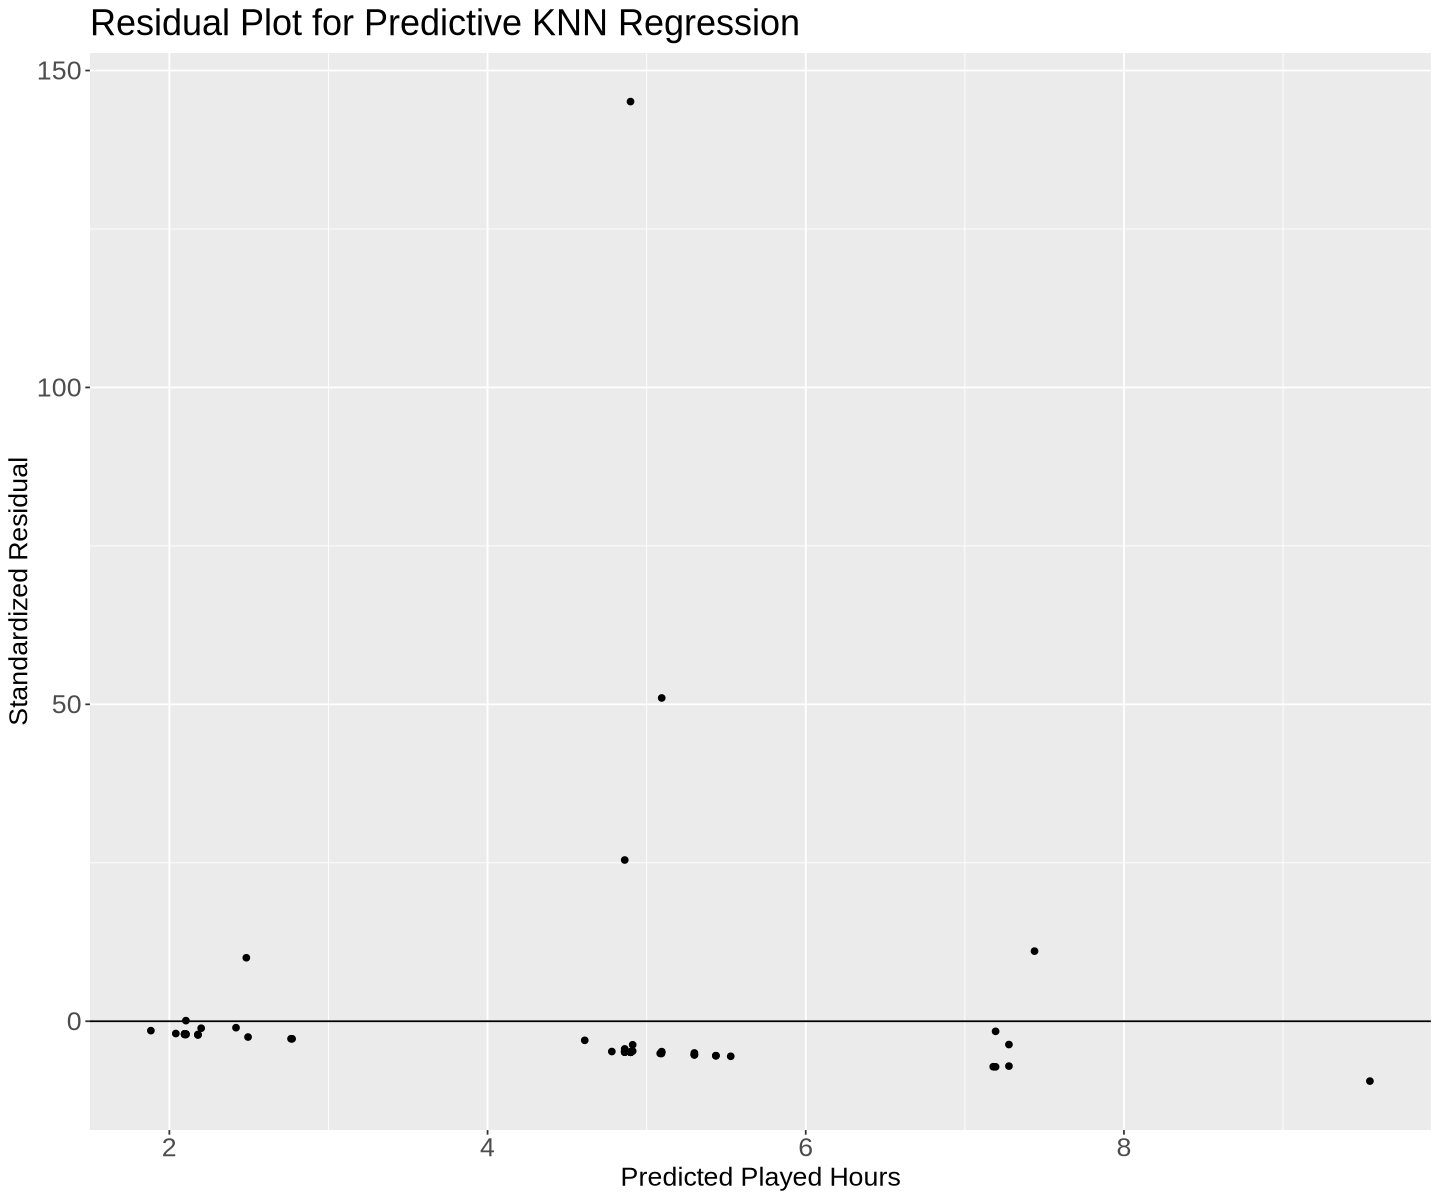

In [8]:
# Create knn regression spec using best k value
predict_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 74) |> 
      set_engine("kknn") |>
      set_mode("regression") 

# Create prediction fit
predict_fit <- workflow() |>
                add_recipe(predict_recipe) |>
                add_model(predict_spec) |>
                fit(data_training)

# Combine predicted values with the test data table
predict_table <- predict_fit |>
                    predict(data_testing) |>
                    bind_cols(data_testing)

# Create a table to analyze the residuals between predicted and observed played hours
residuals <- predict_table |> mutate(residual = played_hours - .pred) |> select(.pred, residual)
                              
# Create a plot comparing the observed played hours with the predicted played hours
options(repr.plot.width = 12, repr.plot.height = 10)
predict_vs_observed <- ggplot(predict_table, aes(x = .pred, y = played_hours)) +
    geom_point() +
    labs(x = "Predicted Played Hours", y = "Observed Played Hours", title = "Comparing Predicted Played Hours To Observed Played Hours") +
    theme(text = element_text(size = 18), axis.title = element_text(size = 16), axis.text = element_text(size = 16))
predict_vs_observed

# Create a residual plot to show the differences between predicted played hours and observed played hours
residual_plot <- ggplot(residuals, aes(x = .pred, y = residual)) +
    geom_point() +
    geom_hline(aes(yintercept = 0)) + 
    labs(x = "Predicted Played Hours", y = "Residual", title = "Residual Plot for Predictive KNN Regression") +
    theme(text = element_text(size = 18), axis.title = element_text(size = 16), axis.text = element_text(size = 16))
residual_plot

## **Discussion**

## **References**